In [1]:
import torch
import torchvision
import pandas as pd
import sys
import matplotlib.pyplot as plt
import math
import torch.nn as nn
import torch.nn.functional as F
device = "cpu"

### Data import

In [2]:
df = pd.read_csv('/Users/alessandrobreccia/data/MNIST/mnist_train.csv')
df = df.drop('label', axis = 1)
df = df.sample(n=5000, random_state=42).reset_index(drop=True)

In [3]:
data = torch.tensor(df.values)/255.0*2 - 1
data = data.view(-1, 1, 28, 28).to(device)
data = F.pad(data, (2, 2, 2, 2), mode='constant', value=-1)

In [4]:
IS = data.shape[-1]

In [5]:
def plot_img(X,t):
    plt.figure(figsize = (16, 6))
    for i in range(len(t)):
        plt.subplot(1, len(t), i+1)
        plt.imshow(X[i][0].cpu(), cmap = 'gray')
        plt.axis('off')
    plt.show()

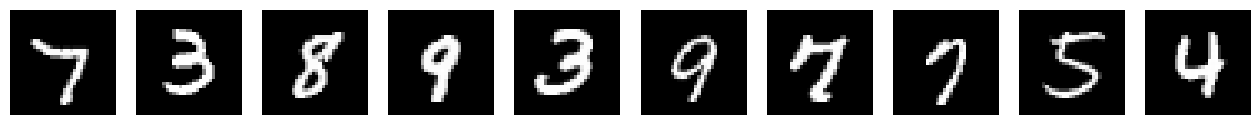

In [6]:
plot_img(data, torch.randint(0, 100, (10,)))

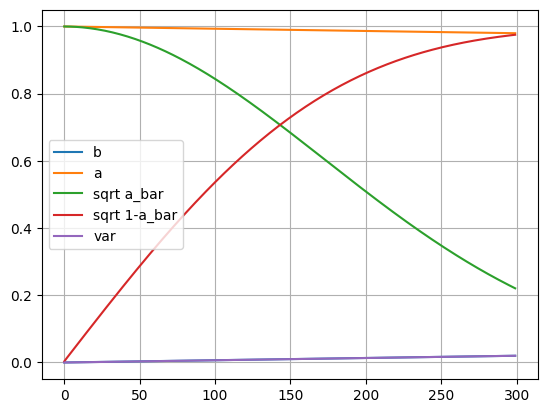

tensor(0.2207) tensor(0.9753)


In [7]:
T = 300
b = torch.linspace(0.00001,0.02,T).to(device)
a = 1.0 - b
a_bar = a.cumprod(dim=0).to(device)
a_prev = F.pad(a_bar[:-1], (1, 0), value=1.0)
var = b*(1-a_prev)/(1-a_bar)

plt.plot(b.cpu(), label = 'b')
plt.plot(a.cpu(), label = 'a')
plt.plot(a_bar.cpu()**0.5, label = 'sqrt a_bar')
plt.plot((1-a_bar.cpu())**0.5, label = 'sqrt 1-a_bar')
plt.plot(var, label = 'var')
plt.grid()
plt.legend()
plt.show()
print(a_bar[-1]**0.5, (1-a_bar[-1])**0.5)

In [8]:
def noisy_img(X, t):
    noise = torch.randn_like(X)
    a_bar_t = a_bar[t].view(-1, 1, 1, 1)
    x_noise = a_bar_t**0.5*X + (1-a_bar_t)**0.5*noise
    return  x_noise, noise

In [9]:
def plot_noise_schedule(X):
    plt.figure(figsize = (16, 6))
    for i,t in enumerate(torch.linspace(0,T-1,10)):
        plt.subplot(1, 10, i+1)
        x, _ = noisy_img(X,int(t))
        plt.imshow(x.view(IS,IS).cpu(), cmap='gray')
        plt.title(f't = {int(t)}')
        plt.axis('off')
    plt.show()

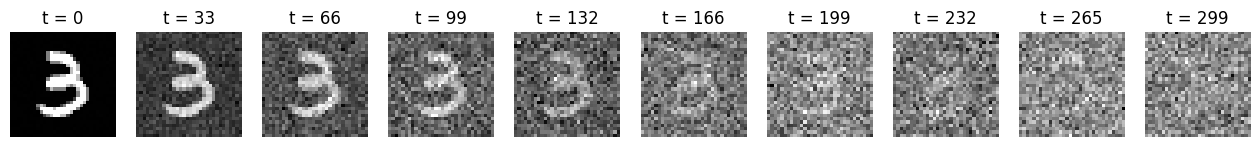

In [10]:
plot_noise_schedule(data[1])

### Denoising Model

In [11]:
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        embeddings = math.log(self.dim*2) / (self.dim - 1)
        embeddings = torch.exp(torch.arange(half_dim) * -embeddings)
        embeddings = t[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings
    
class UBlock(nn.Module):
    def __init__(self, in_channels, out_channels, time_emb_dim):
        super().__init__()

        self.time = TimeEmbedding(time_emb_dim).to(device)
        self.time_emb = nn.Linear(time_emb_dim, out_channels)
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, padding = 1)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, padding = 1)
        self.relu = nn.ReLU()
        self.batchnorm = nn.BatchNorm2d(out_channels)

    def forward(self, x, t):
        # Time embedding 
        time = self.time(t.float())
        # Activation after projection
        time = self.relu(self.time_emb(time))
        # Adjust time embedding to the same shape as x
        time = time.unsqueeze(-1).unsqueeze(-1)
        # first convolution
        x = self.conv1(x)
        x = self.relu(x)
        #x = self.batchnorm(x)
        # Add time embedding
        x = x + time
        # Second convolution
        x = self.conv2(x)
        x = self.relu(x)
        #x = self.batchnorm(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.emb_dim = 128
        self.channels = [1, 32, 64, 128, 256]

        self.pool = nn.MaxPool2d(2)

        self.down_blocks = nn.ModuleList([UBlock(self.channels[i-1], self.channels[i], self.emb_dim) for i in range(1, len(self.channels))])
        self.up_blocks = nn.ModuleList([UBlock(self.channels[i], self.channels[i-1], self.emb_dim) for i in range(len(self.channels)-1, 1, -1)])
        self.out = nn.Conv2d(self.channels[1], 1, 1)
        self.convT = [nn.ConvTranspose2d(self.channels[i], self.channels[i-1], 2, stride=2) for i in range(len(self.channels)-1, 1, -1)]

    def forward(self, x, t):
        downs = []
        for i in range(0, len(self.down_blocks)):
            x = self.down_blocks[i](x, t)
            downs.append(x)
            if i != len(self.down_blocks)-1:
                x = self.pool(x)

        for i in range(len(self.up_blocks)):
            x = self.convT[i](x)
            x = torch.cat((x, downs[len(downs)-i-2]), dim = 1)
            x = self.up_blocks[i](x, t)

        out = self.out(x)
        return out
  

In [12]:
model = UNet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  1844993


UNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_blocks): ModuleList(
    (0): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=128, out_features=32, bias=True)
      (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear(in_features=128, out_features=64, bias=True)
      (conv1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU()
      (batchnorm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): UBlock(
      (time): TimeEmbedding()
      (time_emb): Linear

In [13]:
mus = []
@torch.no_grad()
def sample_at_time(model, x, t):

    cov = b[t]/(1-a_bar[t])**0.5
    noise = model(x, t)
    
    mu = 1/a[t]**0.5*(x-cov*noise)
    mus.append(mu.mean())

    if t == 0:
        return mu
    else:
        return mu + torch.randn_like(noise)*var[t]**0.5

@torch.no_grad()
def sample(model, w=16, h=5, histo=False):

    img_shape = data[0].unsqueeze(0).shape
    img = torch.randn(img_shape)

    times = [290,250,200,150,100,50,15,5,0]
    fig = plt.figure(figsize=(w,h))
    j = 1

    for i in range(0,T)[::-1]:
        t = torch.tensor([i])
        img = sample_at_time(model, img, t)
        img = img/img.max()
        #img = torch.clamp(img, -1.0, 1.0)

        if i in times:
            if histo:
                plt.subplot(1, len(times), j)
                plt.title(f' m = {img.view(-1).mean():03f}')
                #plt.axis('off')
                counts, bins = torch.histogram(img.view(-1))
                plt.hist(bins[:-1], bins, weights=counts, density=True)
                plt.grid()
            else:
                plt.subplot(1, len(times), j)
                plt.title(f't = {int(t.item())}')
                plt.axis('off')
                plt.imshow(img.detach().cpu().view(IS,IS), cmap='gray')
            j += 1
    
    plt.show()
    

Epoch 0 | step 000 Loss: 26332.01171875 


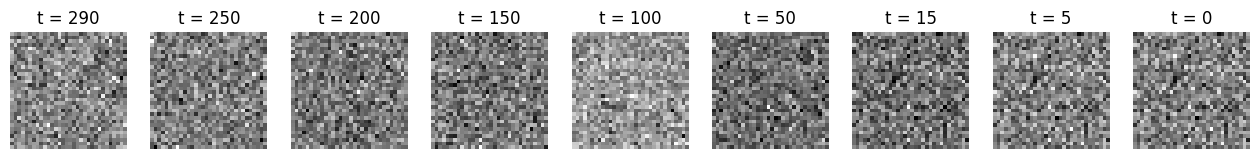

Epoch 0 | step 052 Loss: 11139.67578125 


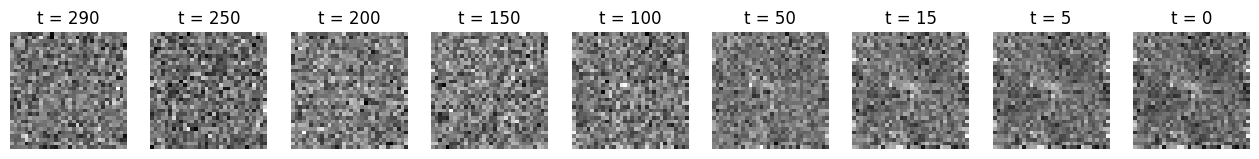

Epoch 0 | step 104 Loss: 9592.3388671875 


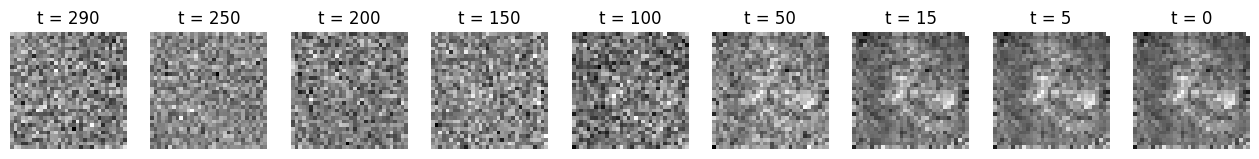

Epoch 1 | step 000 Loss: 8457.6552734375 


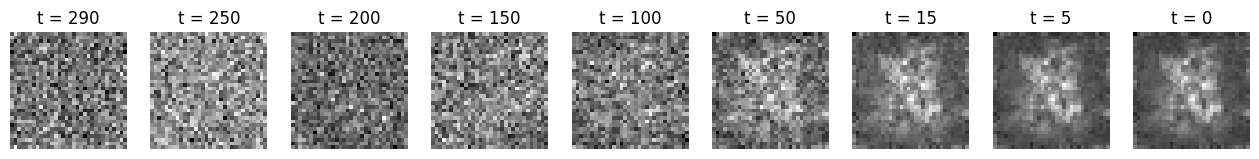

Epoch 1 | step 052 Loss: 7904.421875 


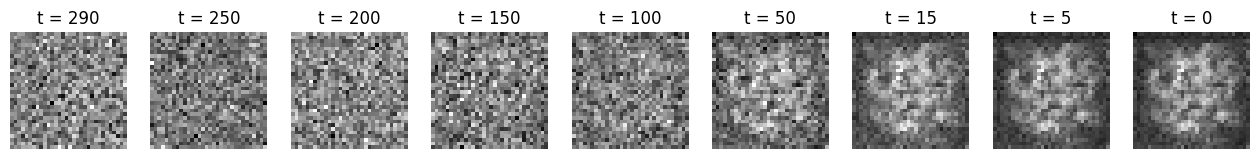

Epoch 1 | step 104 Loss: 6716.7373046875 


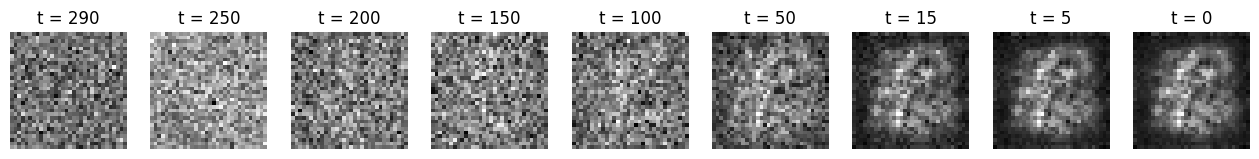

Epoch 2 | step 000 Loss: 6550.30908203125 


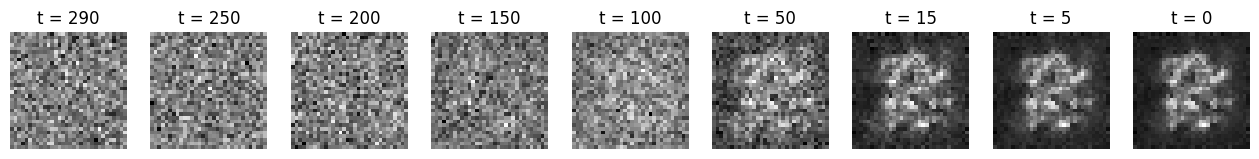

Epoch 2 | step 052 Loss: 4654.1630859375 


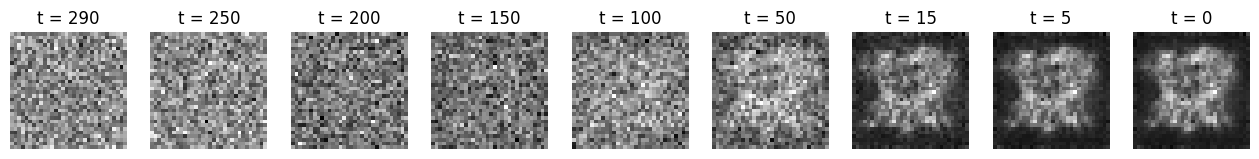

Epoch 2 | step 104 Loss: 5328.43310546875 


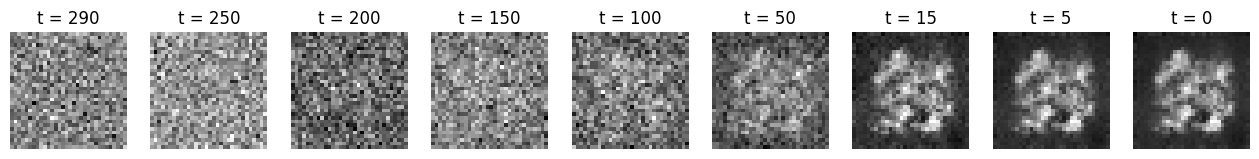

Epoch 3 | step 000 Loss: 5121.7333984375 


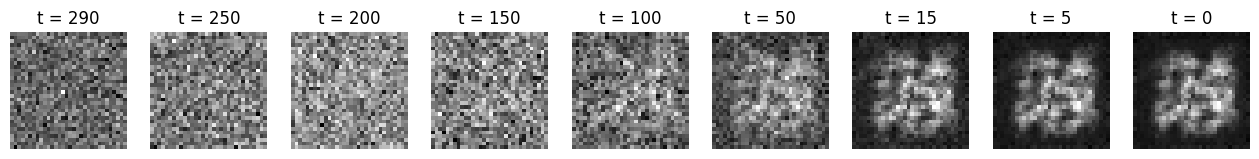

Epoch 3 | step 052 Loss: 5365.544921875 


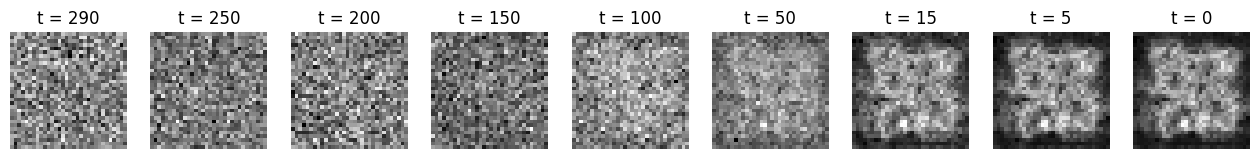

Epoch 3 | step 104 Loss: 5705.1884765625 


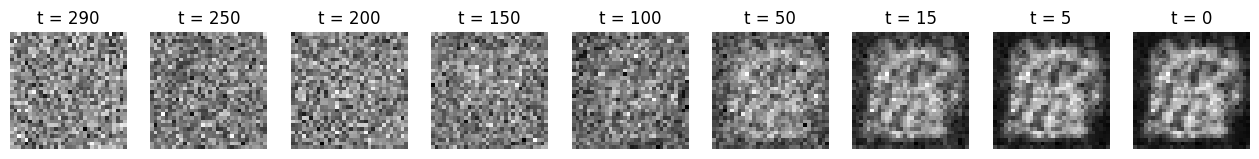

Epoch 4 | step 000 Loss: 3931.78515625 


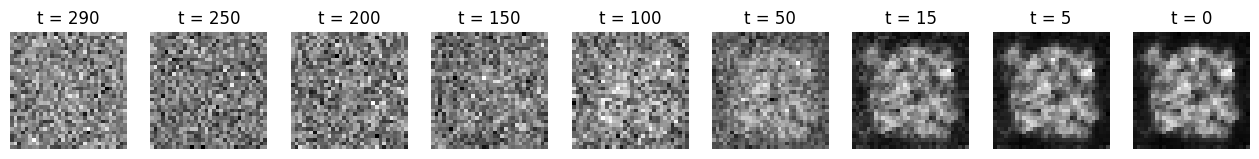

Epoch 4 | step 052 Loss: 5174.16845703125 


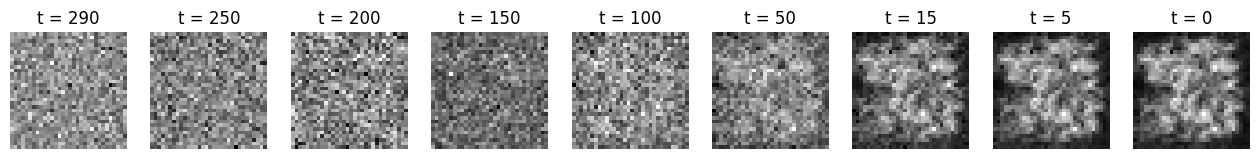

Epoch 4 | step 104 Loss: 4517.3779296875 


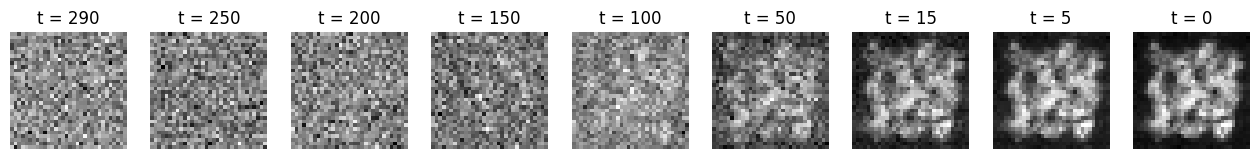

Epoch 5 | step 000 Loss: 5222.89306640625 


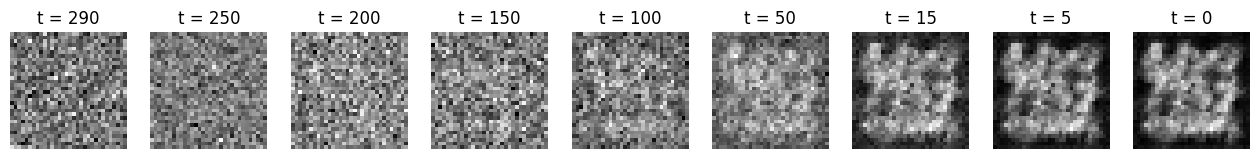

Epoch 5 | step 052 Loss: 4290.86572265625 


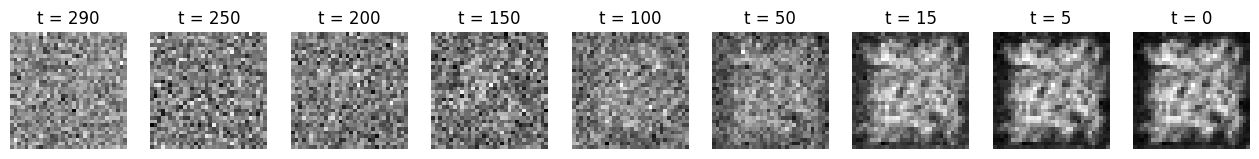

Epoch 5 | step 104 Loss: 4410.01708984375 


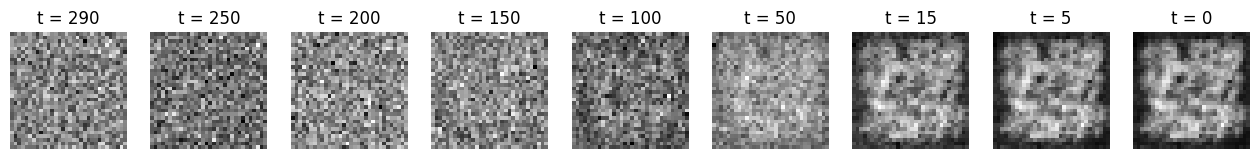

Epoch 6 | step 000 Loss: 4791.98046875 


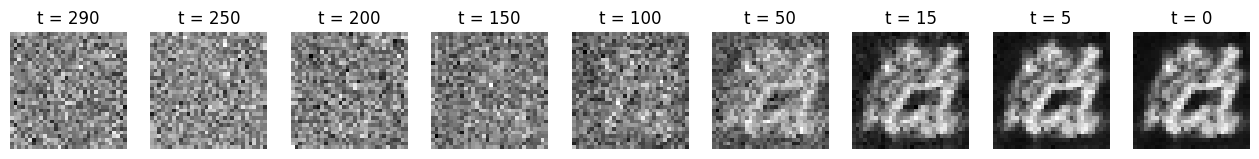

Epoch 6 | step 052 Loss: 4694.125 


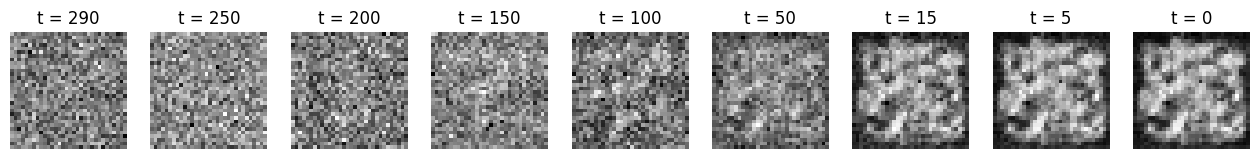

Epoch 6 | step 104 Loss: 3576.36328125 


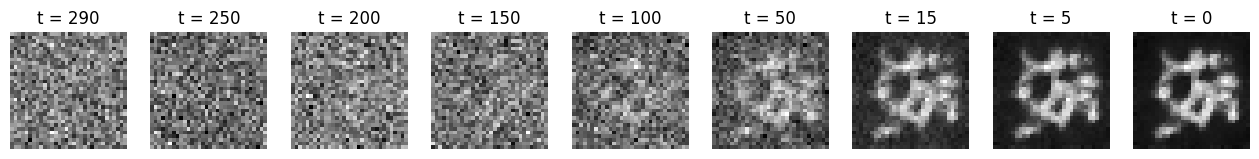

Epoch 7 | step 000 Loss: 5386.001953125 


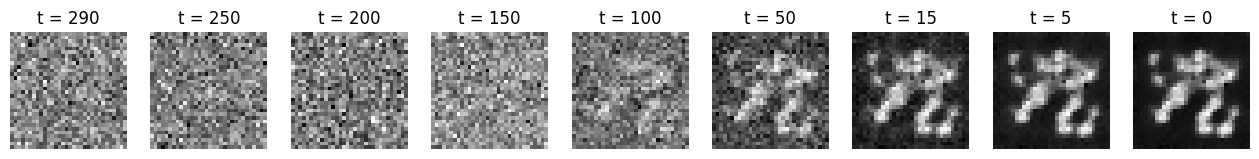

Epoch 7 | step 052 Loss: 4333.03857421875 


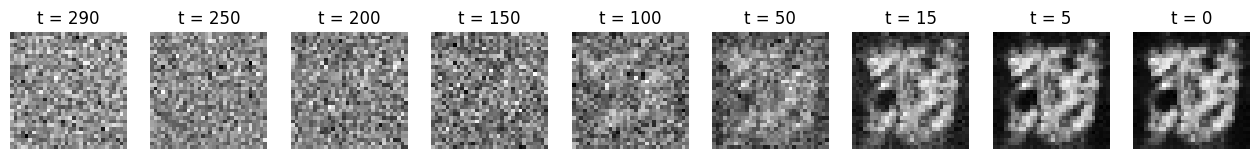

Epoch 7 | step 104 Loss: 3572.136474609375 


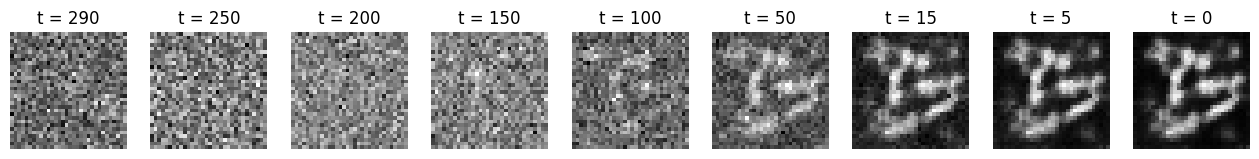

Epoch 8 | step 000 Loss: 3427.4287109375 


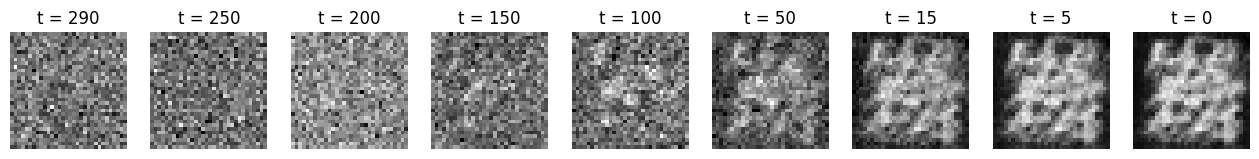

Epoch 8 | step 052 Loss: 3970.86279296875 


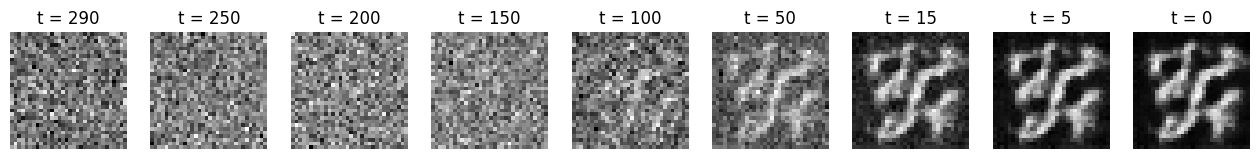

Epoch 8 | step 104 Loss: 4557.4130859375 


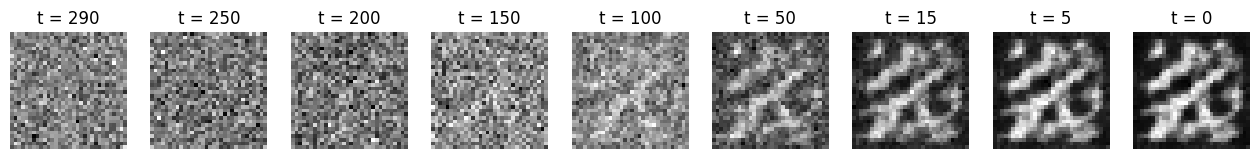

Epoch 9 | step 000 Loss: 3883.31396484375 


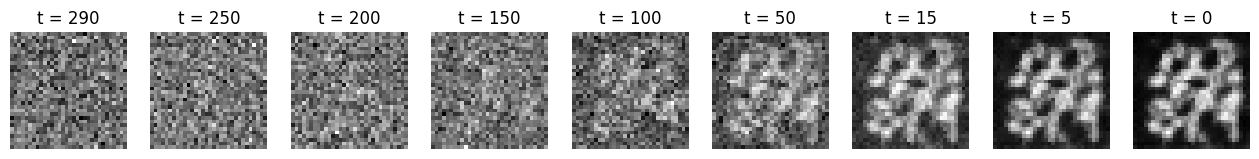

Epoch 9 | step 052 Loss: 3706.373046875 


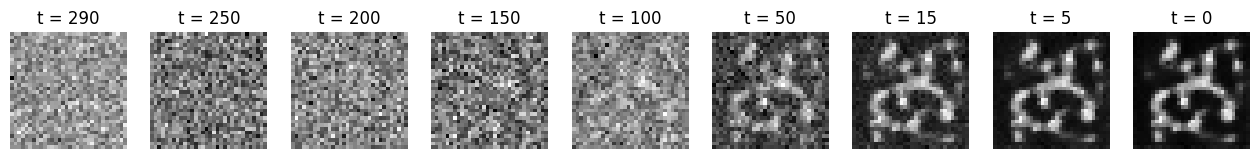

Epoch 9 | step 104 Loss: 4787.24853515625 


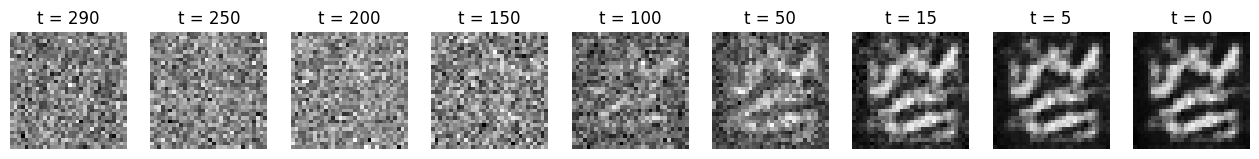

Epoch 10 | step 000 Loss: 3564.24951171875 


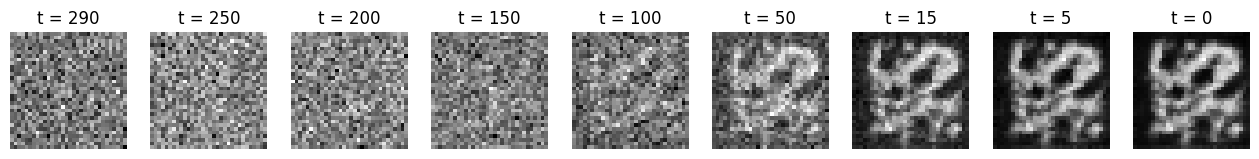

Epoch 10 | step 052 Loss: 3944.80517578125 


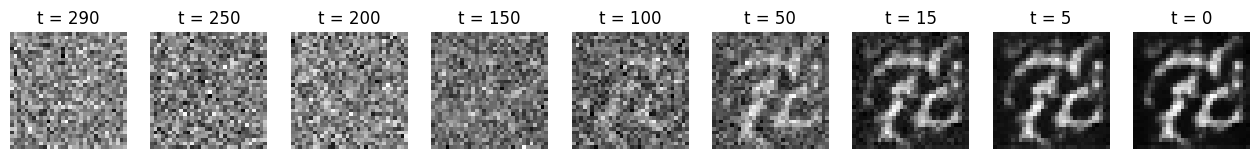

Epoch 10 | step 104 Loss: 3509.548828125 


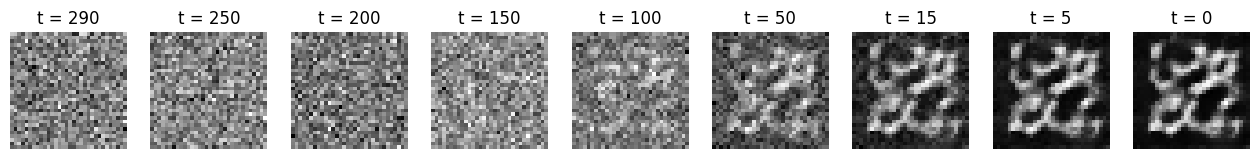

Epoch 11 | step 000 Loss: 3285.518310546875 


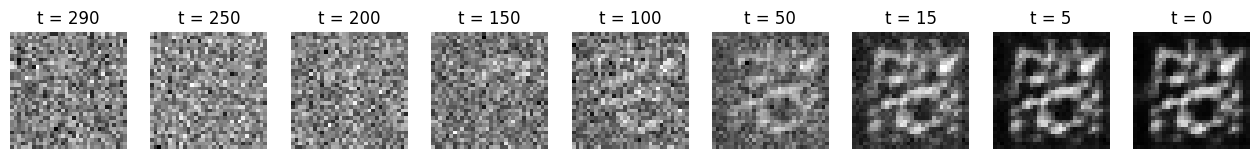

Epoch 11 | step 052 Loss: 3710.107666015625 


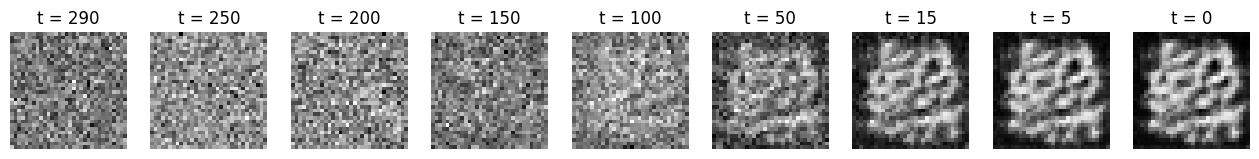

Epoch 11 | step 104 Loss: 4332.9677734375 


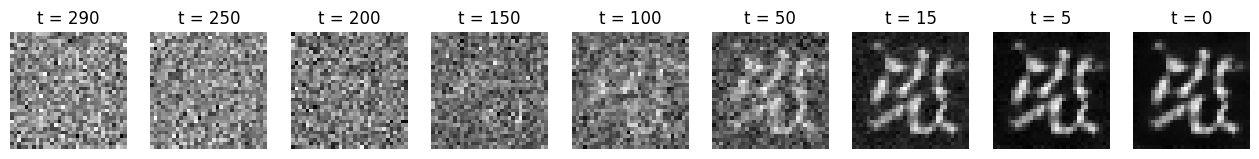

Epoch 12 | step 000 Loss: 3099.900634765625 


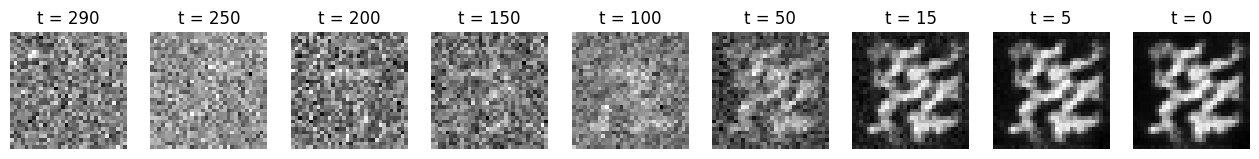

Epoch 12 | step 052 Loss: 3804.0283203125 


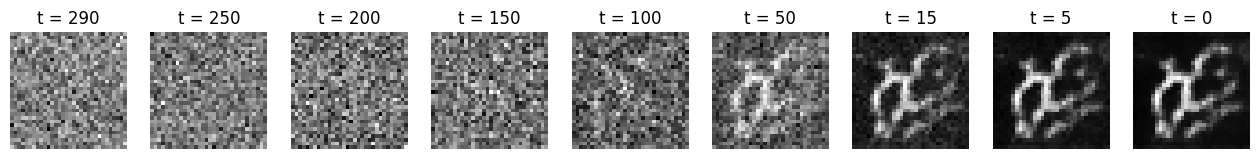

Epoch 12 | step 104 Loss: 4069.104736328125 


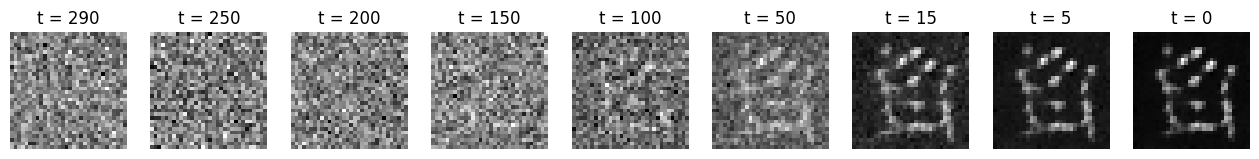

KeyboardInterrupt: 

In [14]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ExponentialLR

loss_hist = []
batch_size = 32
#device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cpu"
model = UNet()
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
#scheduler = ExponentialLR(optimizer, gamma=0.7)
iters = len(data) // batch_size
epochs = 100 
MSE = nn.L1Loss(reduction='sum')

for epoch in range(epochs):
    for i in range(iters):
      optimizer.zero_grad()

      batch = data[i*batch_size:(i+1)*batch_size].to(device)
      t = torch.randint(0, T, (batch_size, ), device=device)

      x_noise, noise = noisy_img(batch, t)
      noise_pred = model(x_noise, t)

      loss = MSE(noise, noise_pred)
      loss_hist.append(loss.detach().clone())
      loss.backward()
      optimizer.step()

      if i % int(iters/3) == 0:
        #scheduler.step()
        print(f"Epoch {epoch} | step {i:03d} Loss: {loss.item()} ")
        sample(model)

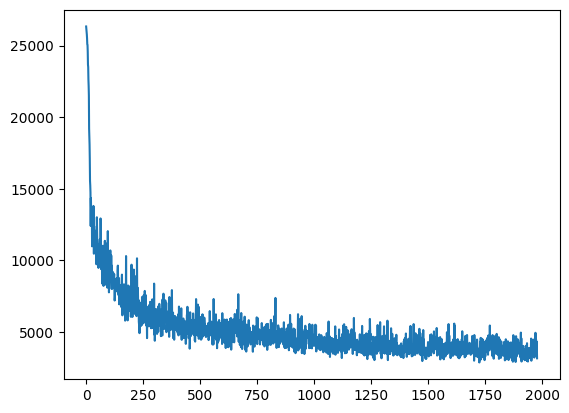

In [15]:
plt.plot(loss_hist)

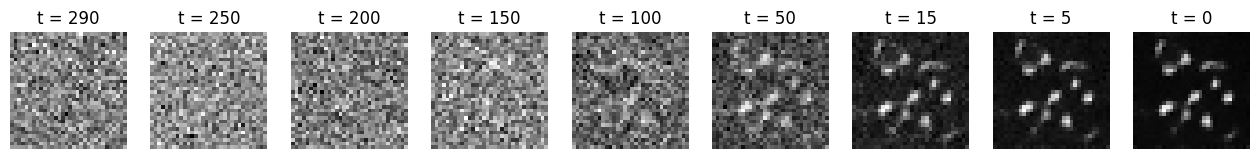

In [22]:
mus = []
sample(model, histo=False)

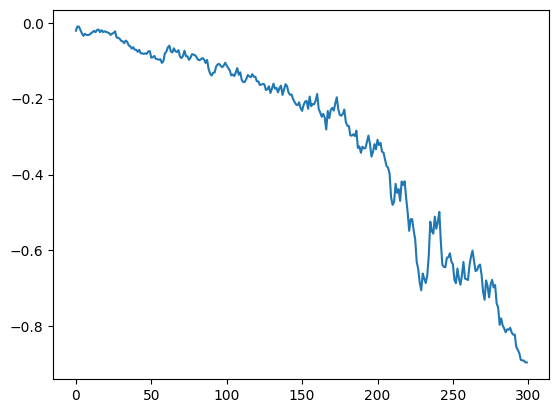

In [23]:
plt.plot(mus)